In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from RuleTree import *
from PivotTree import *

import sys

import pandas as pd
from sklearn.model_selection import train_test_split
from itertools import product
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score, roc_auc_score, balanced_accuracy_score, f1_score, accuracy_score, recall_score, precision_score
from sklearn.datasets import load_breast_cancer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text


In [ ]:
method = 'PT'

validation_folder = 'datasets_stz/validation/validation_results_' + method + '/'
testing_folder = 'datasets_stz/testing/testing_results_' + method + '/'

validation_folder_scaled = 'datasets_stz/validation_scaled/validation_results_' + method + '/'
testing_folder_scaled = 'datasets_stz/testing_scaled/testing_results_' + method + '/'


validation_dfs_names = [validation_folder  + x for x in sorted(os.listdir(validation_folder))[1:]]
testing_dfs_names = [testing_folder  + x for x in sorted(os.listdir(testing_folder))[1:]]


validation_dfs_names_scaled = [validation_folder_scaled  + x for x in sorted(os.listdir(validation_folder_scaled))[1:]]
testing_dfs_names_scaled = [testing_folder_scaled  + x for x in sorted(os.listdir(testing_folder_scaled))[1:]]

In [ ]:
file_names_val_dict = {}

for name_path in validation_dfs_names:
    name_key = name_path
    name_key = (name_key.split('/')[-1])
    name_key = name_key.split('_')
    name_key = name_key[0]
    if name_key[-4:] == '.csv':
        name_key = name_key[:-4]

    #print(name_key)
    file_names_val_dict[name_key] = pd.read_csv(name_path)

file_names_test_dict = {}

for name_path in testing_dfs_names:
    name_key = name_path
    name_key = (name_key.split('/')[-1])
    name_key = name_key.split('_')
    name_key = name_key[0]
    if name_key[-4:] == '.csv':
        name_key = name_key[:-4]

    #print(name_key)
    file_names_test_dict[name_key] = pd.read_csv(name_path)


for name_path in validation_dfs_names_scaled:
    name_key = name_path
    name_key = (name_key.split('/')[-1])
    name_key = name_key.split('_')
    name_key = name_key[0] +'_scaled'
   #print(name_key)

    file_names_val_dict[name_key] = pd.read_csv(name_path)


for name_path in testing_dfs_names_scaled:
    name_key = name_path
    name_key = (name_key.split('/')[-1])
    name_key = name_key.split('_')
    name_key = name_key[0] +'_scaled'
   #print(name_key)

    file_names_test_dict[name_key] = pd.read_csv(name_path)

In [ ]:
if method == 'PT':
    for key, value in file_names_val_dict.items():
        df = value
        df['configuration'] = df['configuration'].str.replace('True', 'False')
        file_names_val_dict[key] = df

    for key, value in file_names_test_dict.items():
        df = value
        df['configuration'] = df['configuration'].str.replace('True', 'False')
        file_names_test_dict[key] = df



In [ ]:
for to_del in ['breast', 'compas', 'german', 'heloc', 'house16',
 'iris', 'page', 'processed', 'sonar', 'vertebral',
 'wine', 'diamonds','gpt', 'electricity']:
    del file_names_test_dict[to_del]

In [ ]:
more_then_20 = ['cars','news']
fiv_to_10 = ['subsetcifar10','subsetmnist','wine_scaled','ElectricDevices','ecg5000']
binary_or_th = [x for x in list(file_names_test_dict.keys()) if x not in more_then_20 + fiv_to_10]

In [ ]:
bins = [(x,x+10) for x in range(0,110,10)]
bins

def find_bin(x,bins):
    #dato un valore trova il bin corrispondente
    for bin in bins:
        if x < bin[1]:
            return bin


#ho un numero finito di bins

In [ ]:
classif = 'KNN5'     #use DT4 to reproduce the experiment with DecisionTree 4 as final classifier
space = 'mapped'
eval_measure = 'average_total_pivots_num'
type_of_pivots = 'y_pivots_discriminative_descriptive'

In [ ]:
def find_values(dataframe_key, max_limit = 110, classif = 'KNN5', space = 'mapped', type_of_pivots = 'y_pivots_discriminative_descriptive', eval_measure = 'average_total_pivots_num'):
    df = file_names_test_dict[dataframe_key]
    filtered_df = df[df['configuration'].str.contains('PT') & df['configuration'].str.contains(type_of_pivots)].sort_values(by=eval_measure, ascending = True)
    filtered_df = filtered_df[filtered_df['configuration'].str.contains(classif)]
    filtered_df = filtered_df[filtered_df['configuration'].str.contains(space)]
    display(filtered_df)
    filtered_df = filtered_df[filtered_df['average_total_pivots_num'] <= 100]
    corresponding_bin = [find_bin(x,bins) for x in filtered_df['average_total_pivots_num']]
    filtered_df['bin'] = corresponding_bin
    # Group by 'bin' and find the index of the row with the maximum 'f1_score' in each group

    max_f1_index = filtered_df.groupby('bin')['average_f1_score'].idxmax()

    # Select the rows with the maximum 'f1_score' for each group
    df_max_f1 = filtered_df.loc[max_f1_index]

    #display(df_max_f1)

    list_scores = []
    for row_id in range(len(df_max_f1)):
        row = df_max_f1.iloc[row_id]
        bin, score, name = row.bin, row.average_f1_score, dataframe_key
        list_scores.append((name,bin,score))





    return list_scores



In [ ]:
def analyze_list(list_results, filter_dataframes):
    bins_dict_values = {}
    for bin in bins[1:]:
        filter_list = [tup for tup in list_results if tup[1] == bin]
        filter_list = [tup for tup in filter_list if tup[0] in filter_dataframes]

        bins_dict_values[bin] = [tup[2] for tup in filter_list]
    return bins_dict_values

In [ ]:
dicitonary_bins_fiv_to_10 = analyze_list(list_results,fiv_to_10)
dicitonary_bins_binary_or_th = analyze_list(list_results,binary_or_th)

In [ ]:
 for key, value in dicitonary_bins_fiv_to_10.items():
        dicitonary_bins_fiv_to_10[key] = (np.array(value).mean(), np.array(value).std())

 for key, value in dicitonary_bins_binary_or_th.items():
        dicitonary_bins_binary_or_th[key] = (np.array(value).mean(), np.array(value).std())

/tmp/ipykernel_1838789/3767019184.py:2: RuntimeWarning: Mean of empty slice.
  dicitonary_bins_fiv_to_10[key] = (np.array(value).mean(), np.array(value).std())
/home/acascione/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/acascione/.local/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/acascione/.local/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/acascione/.local/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1838789/3767019184.py:5: RuntimeWarning: Mean of empty slice.
  dicitonary_bins_binary_or_th[key]

In [ ]:
dictionaries = [dicitonary_bins_binary_or_th, dicitonary_bins_fiv_to_10]

In [ ]:
color_mapping = {0: '#4daf4a', 1 : '#984ea3'}
label_mapping = {0 : r'$l\in[2,3]$', 1 : r'$l\in[5,10]$'}
marker_mapping = {0 :"o", 1: "v"}

/home/acascione/.local/lib/python3.10/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/acascione/.local/lib/python3.10/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/acascione/.local/lib/python3.10/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/acascione/.local/lib/python3.10/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


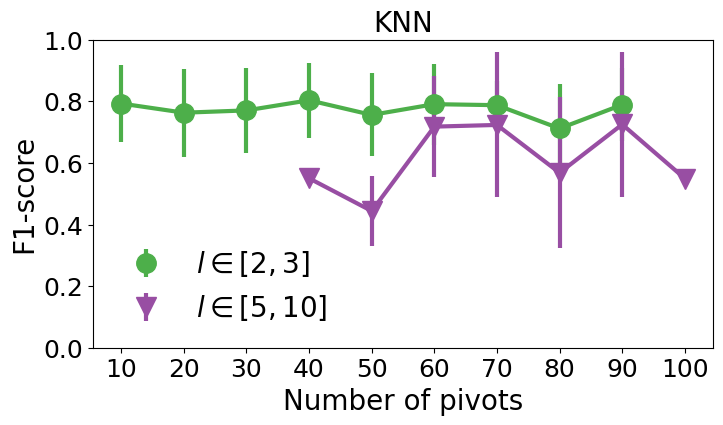

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))  # Adjust the width and height as needed

for i, dictionary_bins in enumerate(dictionaries):
    x_axis = list(dictionary_bins.keys())
    x_axis = np.arange(10,110,10)
    x_axis = [str(x) for x in x_axis]

    y_axis = list(dictionary_bins.values())
    y_axis_mean = [x[0] for x in y_axis]
    std = [x[1] for x in y_axis]

    plt.plot(x_axis, y_axis_mean, color=color_mapping[i], lw=3, markersize=26)
    plt.errorbar(x_axis, y_axis_mean, yerr=std, fmt=marker_mapping[i], color=color_mapping[i], lw=3 , markersize = 14, label=label_mapping[i])

# Setting y-axis limits
plt.ylim(0.0, 1.0)

# Adding labels and legend with increased font size
plt.xlabel('Number of pivots', fontsize=20)
plt.ylabel('F1-score', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'{classif}'[:-1], fontsize=20)

plt.legend(frameon=False, fontsize = 20, loc = 'lower left')



plt.tick_params(axis='both', which='major', labelsize=18)



plt.savefig('sensitivity_KNN.png', format = 'png', dpi = 300, bbox_inches = 'tight')

plt.show()
